In [22]:
import pandas as pd

import numpy as np 
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [3]:

import os
print(os.listdir("./data"))

['abalone.csv']


In [4]:

# Load the Dataset
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
url='./data/abalone.csv'
column_names = ["Sex", "Length", "Diameter", "Height", "Whole_weight", "Shucked_weight", "Viscera_weight", "Shell_weight", "Rings"]
abalone_df = pd.read_csv(url, header=0, names=column_names)

# Display the first few rows
abalone_df.head()


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [5]:
abalone_df.info()
abalone_df.describe()
print(len(abalone_df.isnull()))
# Basic Characteristics
num_samples = abalone_df.shape[0]
num_attributes = abalone_df.shape[1]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB
4177


In [6]:
# Assuming the abalone_df DataFrame has already been created
abalone_df['Sex'] = abalone_df['Sex'].astype('category')  # Convert 'Sex' to categorical type
abalone_df['Length'] = abalone_df['Length'].astype('float64')  # Length as float
abalone_df['Diameter'] = abalone_df['Diameter'].astype('float64')  # Diameter as float
abalone_df['Height'] = abalone_df['Height'].astype('float64')  # Height as float
abalone_df['Whole_weight'] = abalone_df['Whole_weight'].astype('float64')  # Whole weight as float
abalone_df['Shucked_weight'] = abalone_df['Shucked_weight'].astype('float64')  # Shucked weight as float
abalone_df['Viscera_weight'] = abalone_df['Viscera_weight'].astype('float64')  # Viscera weight as float
abalone_df['Shell_weight'] = abalone_df['Shell_weight'].astype('float64')  # Shell weight as float
abalone_df['Rings'] = abalone_df['Rings'].astype('int64')  # Rings as integer

#  print the data types after conversion
print(abalone_df.dtypes)


Sex               category
Length             float64
Diameter           float64
Height             float64
Whole_weight       float64
Shucked_weight     float64
Viscera_weight     float64
Shell_weight       float64
Rings                int64
dtype: object


In [7]:
# Print Characteristics
print(f"Number of Samples: {num_samples}")
print(f"Number of Attributes: {num_attributes}")


Number of Samples: 4177
Number of Attributes: 9


In [8]:
numeric_features = abalone_df.select_dtypes(include=[np.number])
correlation = numeric_features.corr()
correlation

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
Length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
Diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
Height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
Whole_weight,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
Shucked_weight,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
Viscera_weight,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
Shell_weight,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
Rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


In [9]:
#Identify Outliers

numeric_columns = abalone_df.select_dtypes(include='number').columns
# Identify outliers using the IQR method
Q1 = abalone_df[numeric_columns].quantile(0.25)
Q3 = abalone_df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Step 3: Identifying outliers
outlier_info = {}  # Dictionary to hold outlier information

for column in numeric_columns:
    outlier_condition = (abalone_df[column] < (Q1[column] - 1.5 * IQR[column])) | \
                        (abalone_df[column] > (Q3[column] + 1.5 * IQR[column]))
    
    # If there are any outliers for the current column
    if outlier_condition.any():
        outlier_indices = abalone_df[outlier_condition].index.tolist()  # Get the indices of outliers
        outlier_values = abalone_df.loc[outlier_condition, column].values.tolist()  # Get the outlier values
        outlier_info[column] = {'indices': outlier_indices, 'values': outlier_values}

# Step 4: Print outlier information
print("\n eventual outliers Found in Each Column:")
#for column, info in outlier_info.items():
  #  print(f"Column '{column}':")
  #  for i, value in zip(info['indices'], info['values']):
    #    print(f"  Row {i}: Outlier Value = {value}")

# Summary of the number of outliers per column
print("\nSummary of Outliers by Column:")
for column, info in outlier_info.items():
    print(f"Column '{column}' has {len(info['indices'])} outliers.")


 eventual outliers Found in Each Column:

Summary of Outliers by Column:
Column 'Length' has 49 outliers.
Column 'Diameter' has 59 outliers.
Column 'Height' has 29 outliers.
Column 'Whole_weight' has 30 outliers.
Column 'Shucked_weight' has 48 outliers.
Column 'Viscera_weight' has 26 outliers.
Column 'Shell_weight' has 35 outliers.
Column 'Rings' has 278 outliers.


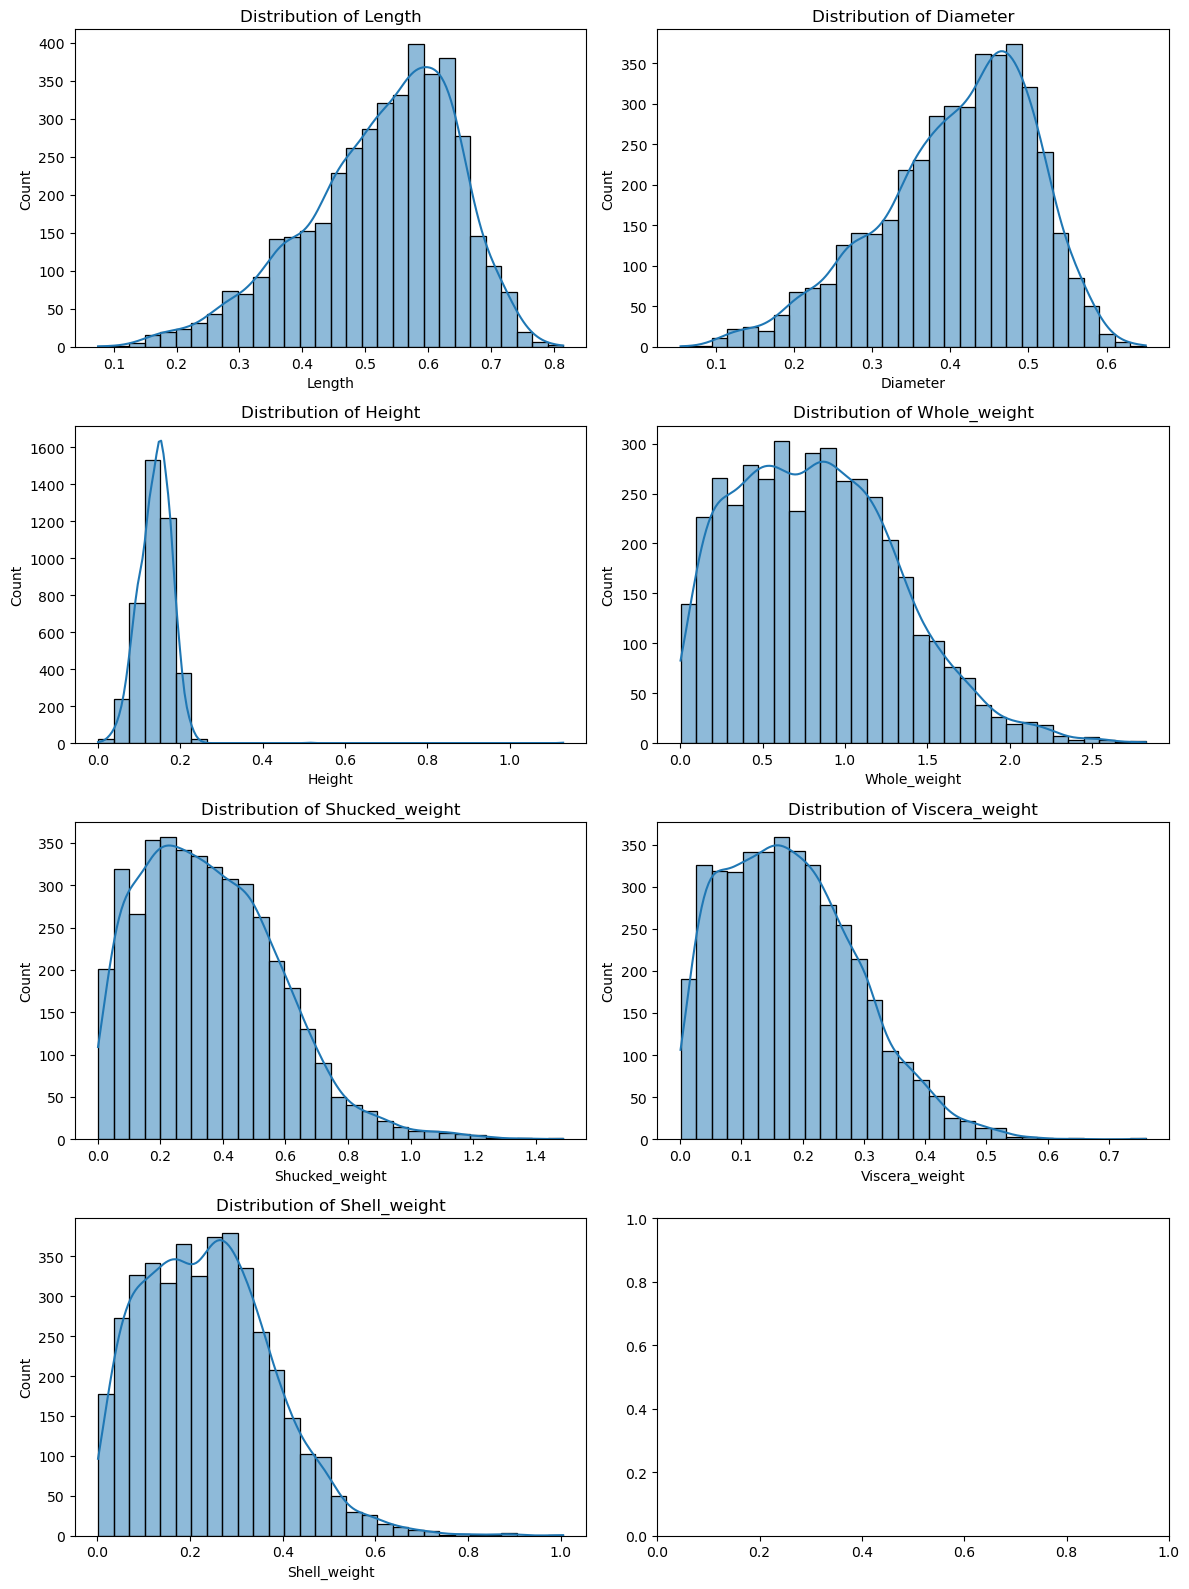

In [10]:
# Distribution of Input Attributes
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))
axes = axes.flatten()

for i, column in enumerate(abalone_df.columns[1:8]):  # Skip 'Sex' and 'Rings'
    sns.histplot(abalone_df[column], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    
plt.tight_layout()
plt.show()

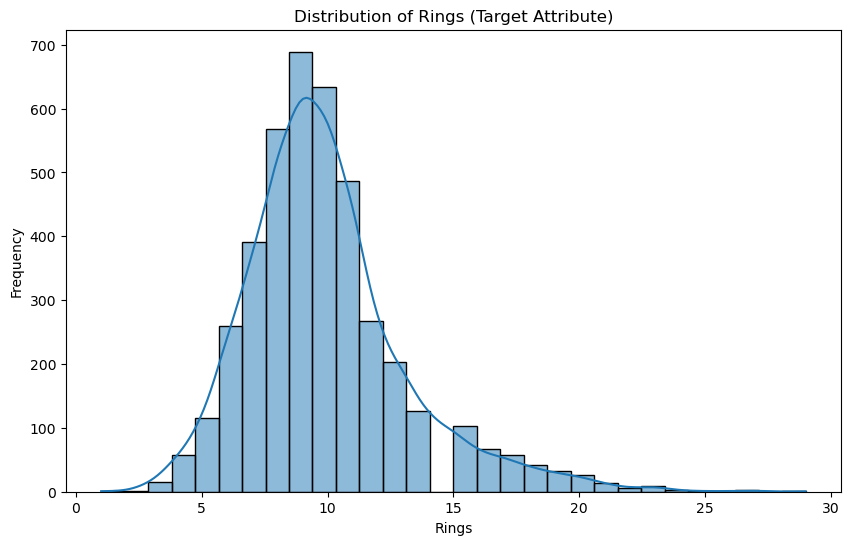

In [11]:
# Distribution of Target Attribute (Rings)
plt.figure(figsize=(10, 6))
sns.histplot(abalone_df['Rings'], bins=30, kde=True)
plt.title('Distribution of Rings (Target Attribute)')
plt.xlabel('Rings')
plt.ylabel('Frequency')
plt.show()

In [12]:
# Handling Categorical Data - One Hot Encoding
abalone_encoded = pd.get_dummies(abalone_df, columns=['Sex'], drop_first=True)

abalone_encoded.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,False,True
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,False,True
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,False,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,False,True
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,True,False


In [13]:
# Define categories based on Rings
def categorize_rings(rings):
    if rings < 8:
        return 'Low'
    elif rings <= 10:
        return 'Medium'
    else:
        return 'High'

abalone_encoded['Rings_Category'] = abalone_encoded['Rings'].apply(categorize_rings)
abalone_encoded.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_I,Sex_M,Rings_Category
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,False,True,High
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,False,True,Low
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,False,False,Medium
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,False,True,Medium
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,True,False,Low


In [14]:
#correlation_matrix = df[selected_columns].corr()
# Step 1: Identify numerical columns
num_cols = abalone_encoded.select_dtypes(include=['float64']).columns.tolist()
num_cols
correlation_matrix = abalone_encoded[num_cols].corr() 

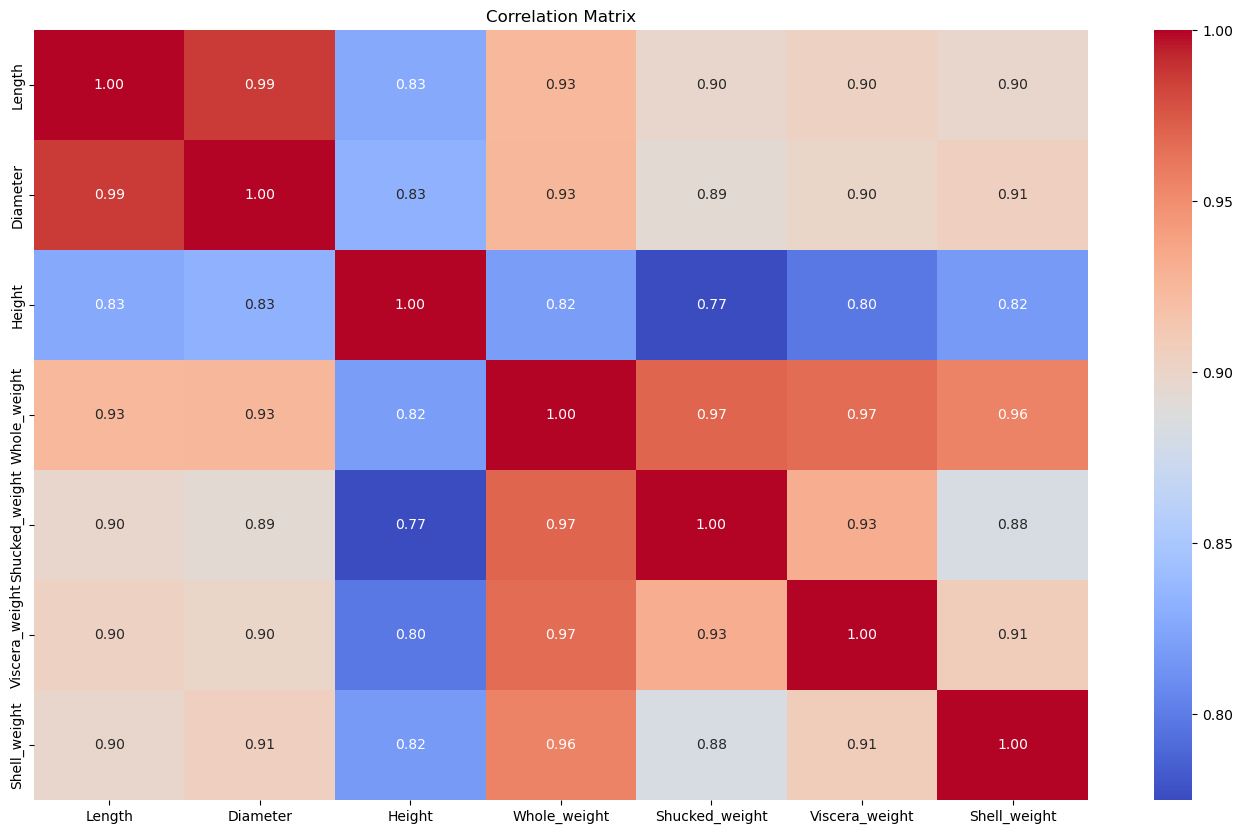

In [15]:
plt.figure(figsize=(17, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [16]:
# Define features and target variable
X = abalone_encoded.drop(['Rings', 'Rings_Category'], axis=1)  # Features
y = abalone_encoded['Rings_Category']  # Target variable

# If needed, encode categorical variables (though Sex_I and Sex_M are already in boolean format)
# No further encoding needed here for Sex_I and Sex_M as they are already in numerical format

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Create the Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Hyperparameter Tuning

n_estimators = number of trees in the foreset
<br>
max_features = max number of features considered for splitting a node
<br>
max_depth = max number of levels in each decision tree
<br>
min_samples_split = min number of data points placed in a node before the node is split
<br>
min_samples_leaf = min number of data points allowed in a leaf node
<br>
bootstrap = method for sampling data points (with or without replacement)
<br>

In [21]:
print('Parameters currently in use:\n')
pprint(classifier.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [25]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, 
<br>
and cv which is the number of folds to use for cross validation. 
<br>
More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time.

In [24]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Work\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
123 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Work\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Work\anaconda\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Work\anaconda\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Work\anaconda\Lib\site-packages\sklearn\utils\_param_validation.py", l

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_classification(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy * 100))
    print('Classification Report:')
    print(classification_report(test_labels, predictions))
    print('Confusion Matrix:')
    print(confusion_matrix(test_labels, predictions))
    
    return accuracy
    
base_model = RandomForestClassifier(n_estimators=10, random_state=42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate_classification(base_model, X_test, y_test)
    
best_random = rf_random.best_estimator_

random_accuracy = evaluate_classification(best_random,X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Model Performance
Accuracy = 67.58%.
Classification Report:
              precision    recall  f1-score   support

        High       0.62      0.70      0.66       276
         Low       0.82      0.71      0.76       180
      Medium       0.66      0.64      0.65       380

    accuracy                           0.68       836
   macro avg       0.70      0.68      0.69       836
weighted avg       0.68      0.68      0.68       836

Confusion Matrix:
[[194   6  76]
 [  5 128  47]
 [114  23 243]]
Model Performance
Accuracy = 70.33%.
Classification Report:
              precision    recall  f1-score   support

        High       0.68      0.68      0.68       276
         Low       0.83      0.73      0.78       180
      Medium       0.67      0.71      0.69       380

    accuracy                           0.70       836
   macro avg       0.73      0.71      0.71       836
weighted avg       0.71      0.70      0.70       836

Confusion Matrix:
[[187   5  84]
 [  2 131  47]
 [ 88 

In [32]:
# Make predictions
y_pred = classifier.predict(X_test)

# Print the confusion matrix and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[190   5  81]
 [  2 126  52]
 [103  25 252]]

Classification Report:
              precision    recall  f1-score   support

        High       0.64      0.69      0.67       276
         Low       0.81      0.70      0.75       180
      Medium       0.65      0.66      0.66       380

    accuracy                           0.68       836
   macro avg       0.70      0.68      0.69       836
weighted avg       0.68      0.68      0.68       836

